# load data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns


In [2]:
np.random.seed(222)

In [3]:
# 바꿀 것!
working_dir = os.path.join("/content/drive/MyDrive/walkmodel","VAT1") # 바꿀 것 

if os.path.exists(working_dir):
    print("{} -- Folder already exists \n".format(working_dir))
else:
    os.makedirs(working_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(working_dir))

os.chdir(working_dir)
os.listdir()

/content/drive/MyDrive/walkmodel/VAT1 -- Folder already exists 



['vat.py', '__pycache__', '3d_tsne_all_after.png', '3d_tsne_all_before.png']

In [4]:
DATA_IN_PATH = os.path.join("/content/drive/MyDrive/walkmodel/data")
DATA_OUT_PATH = working_dir

data_label = pd.read_csv('/content/drive/MyDrive/walkmodel/data/train_ver5/X_label_v3.csv')
data_valid = pd.read_csv('/content/drive/MyDrive/walkmodel/data/train_ver5/X_valid_v3.csv')

data_unlabel = pd.read_csv('/content/drive/MyDrive/walkmodel/data/train_ver5/X_unlabel_v3.csv')

# data_label = pd.read_csv('/content/drive/MyDrive/walkmodel/data/train_ver5/X_valid_v1.csv')
# data_valid = pd.read_csv('/content/drive/MyDrive/walkmodel/data/train_ver5/X_label_v2.csv')

## preprocess

In [5]:
X_label = np.array(data_label.drop(['info'],axis=1))

In [6]:
Y_label = np.array(data_label['info'])

In [7]:
X_unlabel = np.array(data_unlabel.drop(['info'],axis=1))
Y_unlabel = np.array(data_unlabel['info'])

In [8]:
X_all = np.vstack((X_label, X_unlabel))
Y_all = np.concatenate((Y_label, Y_unlabel))

In [9]:
print(X_label.shape)
print(X_unlabel.shape)
print(X_all.shape)

(34, 9)
(4684, 9)
(4718, 9)


In [10]:
print(Y_label.shape)
print(Y_unlabel.shape)
print(Y_all.shape)

(34,)
(4684,)
(4718,)


# VAT

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import vat

torch.manual_seed(222)

## Network model

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(9,100)
        self.linear2 = nn.Linear(100,100)
        self.linear3 = nn.Linear(100,100)
        self.linear4 = nn.Linear(100,2)
        
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [13]:
def train(u):
    vat_loss=vat.VATLoss(ip=2,xi=0.5,eps=0.2)
    cross_entropy = nn.CrossEntropyLoss()
    lds = vat_loss(model,u.float())
    output = model(torch.tensor(X_label).float())
    classification_loss = cross_entropy(output, torch.tensor(Y_label))
    loss = classification_loss + 4.*lds
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return classification_loss, lds

In [36]:
#train 
i_total_step = 0
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=0.001)
dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_all),torch.LongTensor(Y_all))

picdata = []
for epoch in range(60):
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)
    for u , _ in dataloader:
        i_total_step +=1
        classification_loss, lds = train(u)

        ce_losses =classification_loss.item()
        vat_losses = lds.item()
        if i_total_step%100 == 0 or i_total_step==1:
             print("epoch :", epoch)
             print("CE:{0}".format(ce_losses))
             print("Vat:{0}".format(vat_losses))
             print("-----------------------------")

epoch : 0
CE:0.6432221531867981
Vat:1.5549794625258073e-05
-----------------------------
epoch : 1
CE:0.005376332439482212
Vat:0.011517276987433434
-----------------------------
epoch : 2
CE:0.0009965094504877925
Vat:0.005020237062126398
-----------------------------
epoch : 4
CE:0.0004233703075442463
Vat:0.025617968291044235
-----------------------------
epoch : 5
CE:6.447262421716005e-05
Vat:0.007587590254843235
-----------------------------
epoch : 6
CE:0.002514428924769163
Vat:0.007816456258296967
-----------------------------
epoch : 8
CE:0.0001338018773822114
Vat:0.026571014896035194
-----------------------------
epoch : 9
CE:2.44726561504649e-06
Vat:0.018814800307154655
-----------------------------
epoch : 10
CE:4.599911790137412e-06
Vat:0.03351356089115143
-----------------------------
epoch : 12
CE:9.728398435981944e-05
Vat:0.03854896500706673
-----------------------------
epoch : 13
CE:3.909182396455435e-06
Vat:0.00031130106071941555
-----------------------------
epoch : 14


In [37]:
X_valid = np.array(data_valid.drop(['info'],axis=1))
Y_valid = np.array(data_valid['info'])

In [38]:
pred = model(torch.FloatTensor(X_valid))
pred = pred.detach().numpy()

info = pd.Series(np.argmax(pred, axis = 1))

In [39]:
Y_true = pd.Series(Y_valid, dtype=int)
Y_pred = info

In [40]:
pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1775,6,1781
1,0,1735,1735
All,1775,1741,3516


In [19]:
from sklearn.metrics import f1_score

print(f1_score(Y_true, Y_pred))

0.9982738780207134


# TSNE Plot

## 예측 전 plot

In [ ]:
from sklearn.manifold import TSNE

# 자력센서와 광센서는 제거한 버전

X_label =  data_label.drop(['info'], axis=1)
Y_label = data_label['info']

X_unlabel =  data_unlabel.drop(['info'], axis=1)
Y_unlabel = data_unlabel['info']


X_l = X_label.values
Y_l = Y_label.values

X_u = X_unlabel.values
# Y_v = Y_valid.values 
Y_u = np.full( len(X_u) , 2 , dtype=int) # 그래프를 위해서 수정

In [ ]:
X_u.shape

(4684, 9)

In [ ]:
Y_u.shape

(4684,)

In [ ]:
X_all = np.vstack((X_l, X_u))
Y_all = np.concatenate((Y_l, Y_u))

In [ ]:
# 빠른 그래프 작성을 위해서 tsne 부분을 함수에서 빼둠
tsne = TSNE(n_components=3, random_state=222)
X_t = tsne.fit_transform(X_all)

In [ ]:
def tsne_plot_3d_2(x1,y1, name="3dgraph.png"):
  # tsne = TSNE(n_components=3, random_state=222)
  # X_t = tsne.fit_transform(x1)

  fig = plt.figure(figsize=(12,12))
  ax = fig.add_subplot(111,projection='3d')
  
  plt.grid()

  ax.scatter(X_t[np.where(y1 == 0), 0],
             X_t[np.where(y1 == 0), 1],
             X_t[np.where(y1 == 0), 2],
             alpha=1,
             color= "b",
             marker='o',
             s = 100,
             label='NotConcentration')
  
  ax.scatter(X_t[np.where(y1 == 1), 0],
             X_t[np.where(y1 == 1), 1],
             X_t[np.where(y1 == 1), 2],
             alpha=1,
             color= "r",
             marker='^',
             s = 100,
             label='Concentration')
  
  ax.scatter(X_t[np.where(y1 == 2), 0],
             X_t[np.where(y1 == 2), 1],
             X_t[np.where(y1 == 2), 2],
             alpha=0.05,
             color= "grey",
             marker='s',
             s = 100,
             label='unlabel')
  
  ax.set_xlabel("X-axis")
  ax.set_ylabel("Y-axis")
  ax.set_zlabel("Z-axis")
  
  leg = plt.legend(loc='best', fontsize = 'x-large', markerscale = 1.5);
  
  for lh in leg.legendHandles: 
    lh.set_alpha(1)

  plt.savefig(name);
  plt.title("Sensor-data : t-SNE Scatter Plot_Not Predicting")
  plt.show();

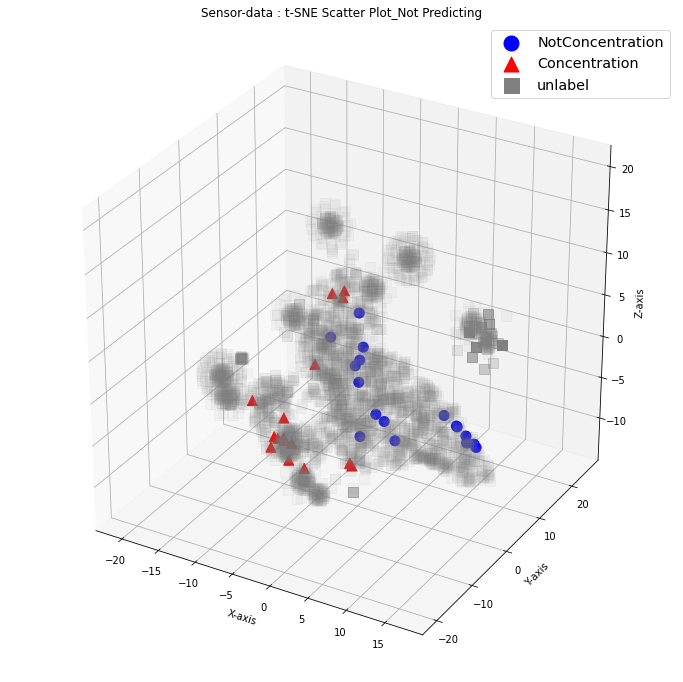

In [ ]:
tsne_plot_3d_2(X_all, Y_all, "3d_tsne_all_before.png")

## 예측 이후 plot

In [ ]:
from sklearn.manifold import TSNE

# 자력센서와 광센서는 제거한 버전

# X_label =  data_label.drop(['info'], axis=1)
# Y_label = data_label['info']

# X_unlabel =  data_unlabel.drop(['info'], axis=1)
# Y_unlabel = data_unlabel['info']


# X_l = X_label.values
# Y_l = Y_label.values

# X_u = X_unlabel.values
# # Y_v = Y_valid.values 
X_unlabel = np.array(data_unlabel.drop(['info'],axis=1))
pred = model(torch.FloatTensor(X_unlabel))
pred = pred.detach().numpy()

Y_u = np.argmax(pred, axis = 1)


In [ ]:
X_all = np.vstack((X_l, X_u))
Y_all = np.concatenate((Y_l, Y_u))

In [ ]:
def tsne_plot_3d_2(x1,y1, name="3dgraph.png"):
  # tsne = TSNE(n_components=3, random_state=222)
  # X_t = tsne.fit_transform(x1)

  fig = plt.figure(figsize=(12,12))
  ax = fig.add_subplot(111,projection='3d')
  
  plt.grid()

  ax.scatter(X_t[np.where(y1 == 0), 0],
             X_t[np.where(y1 == 0), 1],
             X_t[np.where(y1 == 0), 2],
             alpha=0.2,
             color= "b",
             marker='o',
             s = 50,
             label='NotConcentration')
  
  ax.scatter(X_t[np.where(y1 == 1), 0],
             X_t[np.where(y1 == 1), 1],
             X_t[np.where(y1 == 1), 2],
             alpha=0.2,
             color= "r",
             marker='^',
             s = 50,
             label='Concentration')
  
  ax.scatter(X_t[np.where(y1 == 2), 0],
             X_t[np.where(y1 == 2), 1],
             X_t[np.where(y1 == 2), 2],
             alpha=0.2,
             color= "grey",
             marker='s',
             s = 50,
             label='unlabel')
  
  ax.set_xlabel("X-axis")
  ax.set_ylabel("Y-axis")
  ax.set_zlabel("Z-axis")
  
  leg = plt.legend(loc='best', fontsize = 'x-large', markerscale = 2);
  
  for lh in leg.legendHandles: 
    lh.set_alpha(1)
  
  plt.savefig(name);
  plt.title("Sensor-data : t-SNE Scatter Plot_Predicting")
  plt.show();

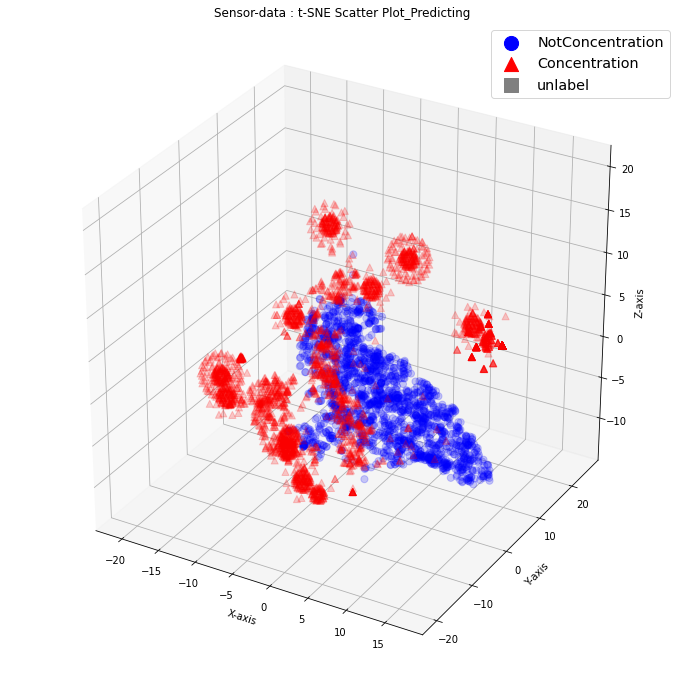

In [ ]:
tsne_plot_3d_2(X_all, Y_all, "3d_tsne_all_after.png")

## train w/o VAT

In [ ]:
X_label.shape

(34, 9)

In [ ]:
i_total_step = 0
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=0.001)
dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_label),torch.LongTensor(Y_label))
win = None
picdata_nom = []
for epoch in range(100):
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)
    for u , _ in dataloader:
        i_total_step +=1
        
        cross_entropy = nn.CrossEntropyLoss()
        
        output = model(torch.tensor(X_label).float())
        classification_loss = cross_entropy(output, torch.tensor(Y_label))
        
        loss = classification_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## PL 전 성능평가

In [ ]:
pred = model(torch.FloatTensor(X_valid))
pred = pred.detach().numpy()

info = pd.Series(np.argmax(pred, axis = 1))

In [ ]:
Y_true = pd.Series(Y_valid, dtype=int)
Y_pred = info

In [ ]:
pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1711,70,1781
1,8,1727,1735
All,1719,1797,3516


In [ ]:
from sklearn.metrics import f1_score

f1_score(Y_true, Y_pred)

0.977916194790487

In [ ]:
pred_unlabel = model(torch.FloatTensor(X_unlabel))
pred_unlabel = pred_unlabel.detach().numpy()

Y_pred_unlabel = pd.Series(np.argmax(pred_unlabel, axis = 1))

Y_pred_unlabel = np.array(Y_pred_unlabel)
Y_all = np.concatenate((Y_label, Y_pred_unlabel))

In [ ]:
#train 
i_total_step = 0
# model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=0.001)
dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_all),torch.LongTensor(Y_all))
win = None
picdata_nom = []
for epoch in range(100):
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)
    for u , _ in dataloader:
        i_total_step +=1
        
        cross_entropy = nn.CrossEntropyLoss()
        
        output = model(torch.tensor(X_all).float())
        classification_loss = cross_entropy(output, torch.tensor(Y_all))
        
        loss = classification_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
X_valid = np.array(data_valid.drop(['info'],axis=1))
Y_valid = np.array(data_valid['info'])

In [ ]:
pred = model(torch.FloatTensor(X_valid))
pred = pred.detach().numpy()

info = pd.Series(np.argmax(pred, axis = 1))

In [ ]:
Y_true = pd.Series(Y_valid, dtype=int)
Y_pred = info

In [ ]:
pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1707,74,1781
1,8,1727,1735
All,1715,1801,3516


In [ ]:
from sklearn.metrics import f1_score

f1_score(Y_true, Y_pred)

In [ ]:
#@title
